In [1]:
import cv2
import numpy as np
from scipy.signal import convolve2d
from skimage import restoration
from skimage.util import random_noise
from skimage import filters
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from skimage.measure import find_contours

In [ ]:
"""import os


# # Function to extract frames from a video
def extract_frames(video_path, output_folder):
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Open the video file
    video_capture = cv2.VideoCapture(video_path)
    success, frame = video_capture.read()
    count = 0

    # Loop through the video frames
    while success:
        # Save frame as JPEG file
        frame_path = os.path.join(output_folder, f"f_{count}.jpg")
        cv2.imwrite(frame_path, frame)  # Save frame as JPEG file
        success, frame = video_capture.read()
        count += 1

    video_capture.release()


# Example usage
video_path = "Project Video.mp4"
output_folder = "projectData"
extract_frames(video_path, output_folder)"""

In [2]:
def word_bounder(image, s, e, sc, ec):
    image = Image.fromarray(image)
    draw = ImageDraw.Draw(image)
    width, height = image.size

    # Initialize variables
    start = None
    count = 0

    # Set the RGB values and the number of pixels you're looking for
    R_value = 250
    G_value = 250
    B_value = 245
    num_pixels = 1
    num_columns = 25

    # Set the start and end rows for the region of interest
    start_row = s
    end_row = e
    space = 7

    # Iterate over the image column by column
    for x in range(sc - 8, ec + 10):
        column = [image.getpixel((x, y)) for y in range(start_row, end_row)]
        filtered = [
            pixel
            for pixel in column
            if pixel[0] > R_value and pixel[1] > G_value and pixel[2] > B_value
        ]
        # Check if the number of filtered pixels is less than or equal to num_pixels
        if len(filtered) <= num_pixels:
            count += 1
            if count == num_columns:
                start = x - num_columns + 1
        else:
            if start is not None:
                # Draw a vertical line at the start and end of the region
                draw.line(
                    [(start + space, start_row), (start + space, end_row)],
                    fill="green",
                    width=2,
                )
                draw.line(
                    [(x - space, start_row), (x - space, end_row)],
                    fill="green",
                    width=2,
                )

            start = None
            count = 0

    # If the last region extends to the end of the image
    if start is not None:
        draw.line([(start + 2, start_row), (start + 2, end_row)], fill="green", width=2)
        draw.line([(width - 3, start_row), (width - 3, end_row)], fill="green", width=2)
    image = np.array(image)
    return image


In [7]:
def process_frame(frame, flag=0):
    image = cv2.imread(rf"D:\MO3 LAP\Image processing\projectData\f_{frame}.jpg")
    roi = image[630:, 150:1110]

    # Convert ROI to HSV format
    hsv = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
    if flag == 1:

        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2HSV))
        plt.title("HSV")
        plt.show()
    # Define lower/upper ranges for color segmentation
    lower = np.array([0, 0, 0])
    upper = np.array([179, 14, 255])

    # Create binary mask
    mask_roi = cv2.inRange(hsv, lower, upper)

    # Create mask with the same shape as the original image
    mask = np.zeros_like(image[:, :, 0])

    mask[630:, 150:1110] = mask_roi

    roi_rgb = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)

    # print(mask.shape)
    # Create horizontal kernel and dilate to connect text characters
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
    dilate = cv2.dilate(mask, kernel, iterations=5)

    result = 255 - cv2.bitwise_and(dilate, mask)

    # Convert color space for matplotlib
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    dilate = cv2.cvtColor(dilate, cv2.COLOR_BGR2RGB)
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    dilate_gray = cv2.cvtColor(dilate, cv2.COLOR_RGB2GRAY)

    if flag == 1:

        plt.imshow(mask)
        plt.title("Mask")
        plt.show()
        plt.imshow(dilate)
        plt.title("Dilate")
        plt.show()
        """plt.imshow(dilate_gray)
        plt.title("Dilate gray")
        plt.show()"""
        plt.imshow(result)
        plt.title("Result")
        plt.show()

    # Find contours
    cnts = find_contours(dilate_gray, 0.8)

    if len(cnts) > 0:

        cnts = cnts[0]

        # print(cnts.shape)
        y_min_value = np.min(cnts[:, 0])

        y_max_value = np.max(cnts[:, 0])
        # print(int(y_min_value.round()))
        # print(int(y_max_value.round()))

        diff = y_max_value - y_min_value

        avg = (y_min_value + y_max_value) // 2
        # print(int(diff.round()))

        # print(int(avg.round()))
        x_min_value = np.min(cnts[:, 1])

        x_max_value = np.max(cnts[:, 1])
        # print(int(x_min_value.round()))
        # print(int(x_max_value.round()))

        xdiff = x_max_value - x_min_value
        # print(int(xdiff.round()))
        x_min_value = np.int64(x_min_value.round())

        x_max_value = np.int64(x_max_value.round())

        y_min_value = np.int64(y_min_value.round())

        y_max_value = np.int64(y_max_value.round())

        avg = np.int64(avg.round())

        diff = np.int64(diff.round())

        # print(diff)

        if diff > 100:  # containnnn 2 liness

            cv2.rectangle(
                image,
                (x_max_value, avg - 2),
                (x_min_value, y_min_value),
                (0, 0, 255),
                2,
            )
       
            image = word_bounder(image, y_min_value, avg - 2, x_min_value, x_max_value)
        

            cv2.rectangle(
                image,
                (x_max_value, y_max_value - 10),
                (x_min_value, avg + 2),
                (0, 0, 255),
                2,
            )
            image = word_bounder(
                image, avg + 2, y_max_value - 10, x_min_value, x_max_value
            )
            if flag:
                plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                plt.title("Final frame")
                plt.show()

        else:

            cv2.rectangle(
                image,
                (x_max_value, y_max_value),
                (x_min_value, y_min_value),
                (0, 0, 255),
                2,
            )
            image = word_bounder(
                image, y_min_value, y_max_value, x_min_value, x_max_value
            )
            if flag:

                plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                plt.title("Final frame")
                plt.show()
    else:
        if flag:
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.title("Final frame")
            plt.show()
    return image

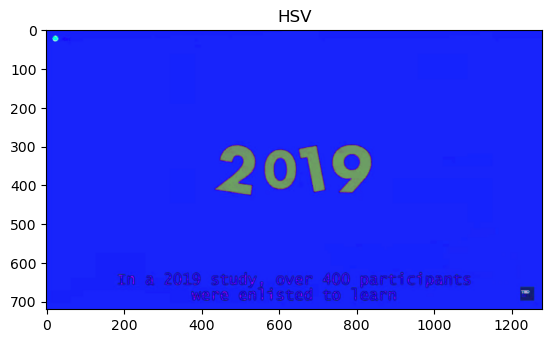

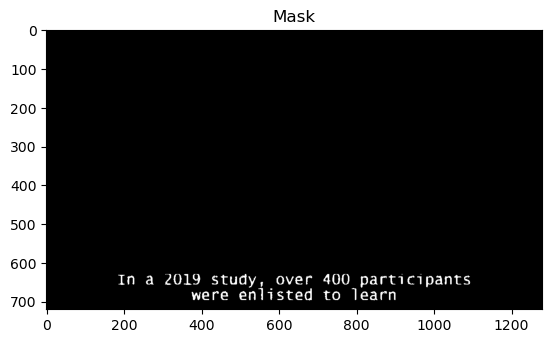

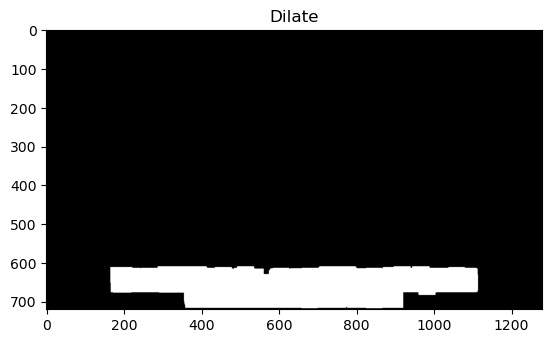

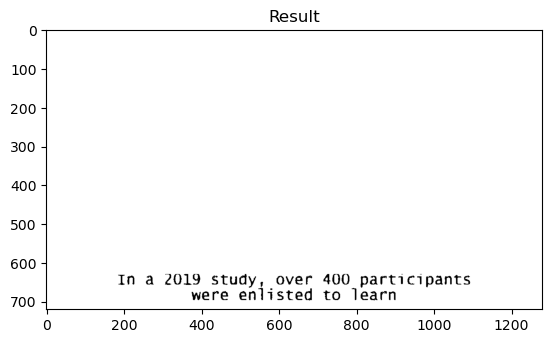

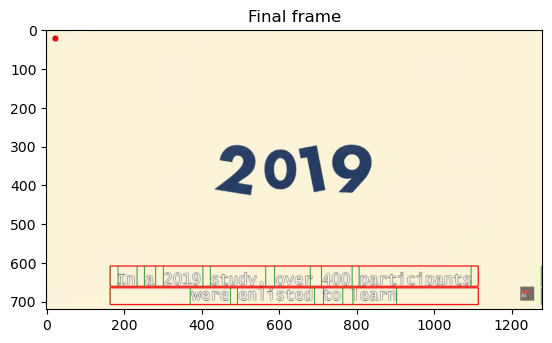

In [8]:
temp_image = process_frame(50, 1)

In [42]:
# Define the codec using VideoWriter_fourcc and create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter("new_video\\video2.mp4", fourcc, 30.0, (1280, 720))


# Iterate over all frames
for frame_number in range(7950):
    # Read the frame

    # Process the frame
    processed_frame = process_frame(frame_number)

    # Write the processed frame to file
    out.write(processed_frame)

# Release the VideoWriter
out.release()

In [ ]:
def nothing(x):
    pass

# Load image
image = cv2.imread(rf"D:\MO3 LAP\Image processing\projectData\f_{frame}.jpg")
image = image[630:, 150:1110]

# Create a window
cv2.namedWindow('image')

# Create trackbars for color change
# Hue is from 0-179 for Opencv
cv2.createTrackbar('HMin', 'image', 0, 179, nothing)
cv2.createTrackbar('SMin', 'image', 0, 255, nothing)
cv2.createTrackbar('VMin', 'image', 0, 255, nothing)
cv2.createTrackbar('HMax', 'image', 0, 179, nothing)
cv2.createTrackbar('SMax', 'image', 0, 255, nothing)
cv2.createTrackbar('VMax', 'image', 0, 255, nothing)

# Set default value for Max HSV trackbars
cv2.setTrackbarPos('HMax', 'image', 179)
cv2.setTrackbarPos('SMax', 'image', 255)
cv2.setTrackbarPos('VMax', 'image', 255)

# Initialize HSV min/max values
hMin = sMin = vMin = hMax = sMax = vMax = 0
phMin = psMin = pvMin = phMax = psMax = pvMax = 0

while(1):
    # Get current positions of all trackbars
    hMin = cv2.getTrackbarPos('HMin', 'image')
    sMin = cv2.getTrackbarPos('SMin', 'image')
    vMin = cv2.getTrackbarPos('VMin', 'image')
    hMax = cv2.getTrackbarPos('HMax', 'image')
    sMax = cv2.getTrackbarPos('SMax', 'image')
    vMax = cv2.getTrackbarPos('VMax', 'image')

    # Set minimum and maximum HSV values to display
    lower = np.array([hMin, sMin, vMin])
    upper = np.array([hMax, sMax, vMax])

    # Convert to HSV format and color threshold
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, lower, upper)
    result = cv2.bitwise_and(image, image, mask=mask)

    # Print if there is a change in HSV value
    if((phMin != hMin) | (psMin != sMin) | (pvMin != vMin) | (phMax != hMax) | (psMax != sMax) | (pvMax != vMax) ):
        print("(hMin = %d , sMin = %d, vMin = %d), (hMax = %d , sMax = %d, vMax = %d)" % (hMin , sMin , vMin, hMax, sMax , vMax))
        phMin = hMin
        psMin = sMin
        pvMin = vMin
        phMax = hMax
        psMax = sMax
        pvMax = vMax

    # Display result image
    cv2.imshow('image', result)
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()